# **Этап 3. Проверка гипотез**

In [33]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.stats import shapiro

In [34]:
df = pd.read_excel("all_vacancies_clean.xlsx")

In [35]:
df.head()

,Unnamed: 0,id,name,company,city,key_skills,salary_from,salary_to,experience,schedule,alternate_url,salary,area
0,8,114673345,BI-аналитик,ЛУКОЙЛ,Москва,"Power BI, Apache Airflow, SQL",150000,150000,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/114673345,150000,Мск_МО
1,11,117262495,Аналитик,Всм,Москва,"Контроль и анализ ценообразования, Unit-эконом...",80000,120000,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117262495,100000,Мск_МО
2,13,116537974,Системный аналитик (junior+),ИТРУМ,Ростов-на-Дону,"Системный аналитик, UML, SQL, Функциональные т...",70000,80000,Нет опыта,Удаленная работа,https://hh.ru/vacancy/116537974,75000,ЮФО
3,14,117347065,Marketing Data Analyst,Топассистент,Москва,"Python, SQL, MS Excel, Tableau, Бизнес-анализ,...",400000,400000,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/117347065,400000,Мск_МО
4,15,116767298,Crypto-аналитик,Евсеев Сергей Владимирович,Москва,"Английский язык, Аналитический склад ума, Анал...",150000,450000,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/116767298,300000,Мск_МО



---


**Гипотеза 1: Вариация зарплат в зависимости от уровня опыта**


---


H0: Средние зарплаты одинаковы для всех уровней опыта

H1: Средние зарплаты различаются между уровнями опыта

In [36]:
df_clean_1 = df[['experience', 'salary', 'area']].dropna()
experience_levels = df_clean_1['experience'].unique()

Результаты теста на нормальность (Shapiro-Wilk):
{'От 1 года до 3 лет': np.False_, 'Нет опыта': np.False_, 'От 3 до 6 лет': np.False_, 'Более 6 лет': np.True_}

Результат ANOVA:
F-статистика: 3.34, p-значение: 0.0188
Отвергаем H0: Средние зарплаты различаются по уровням опыта.

Результат пост-хок теста Тьюки:
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
      group1             group2         meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------------------------------
       Более 6 лет          Нет опыта -118615.4751 0.9685 -788478.2506 551247.3004  False
       Более 6 лет От 1 года до 3 лет  -79910.4044 0.9895 -740091.5094 580270.7007  False
       Более 6 лет      От 3 до 6 лет  106563.9538 0.9771 -565737.8246 778865.7323  False
         Нет опыта От 1 года до 3 лет   38705.0707 0.9211 -118369.5011 195779.6425  False
         Нет опыта      От 3 до 6 лет   225179.429 0.0219  

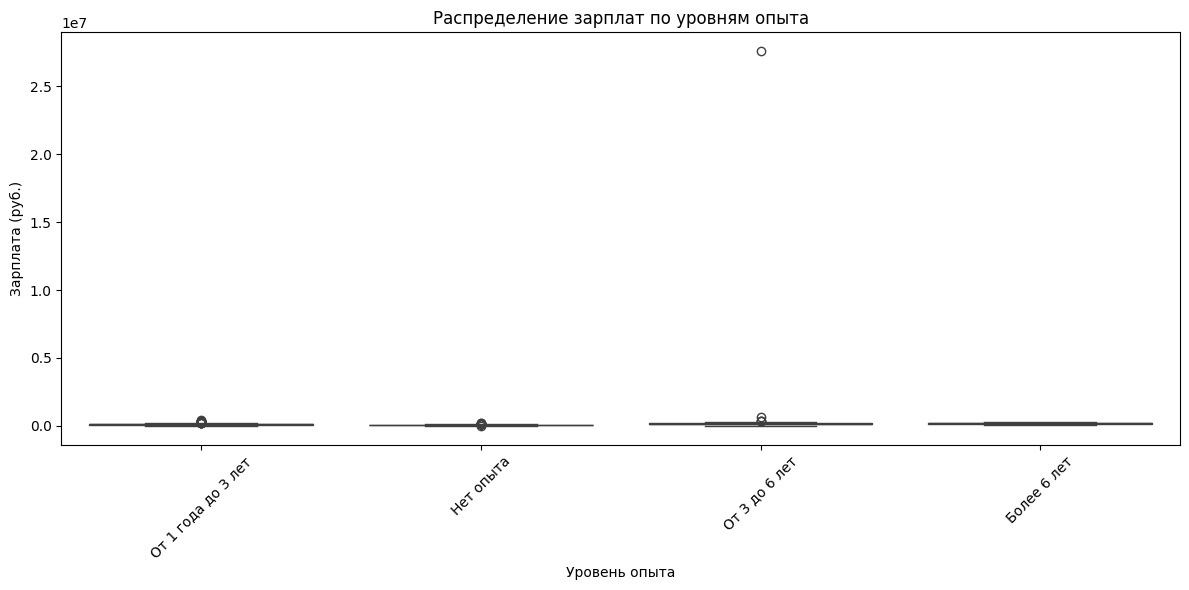


Вывод:
Анализ подтверждает, что зарплаты зависят от уровня опыта. Вакансии с опытом 'От 3 до 6 лет' или 'Более 6 лет' имеют более высокие зарплаты.


In [37]:
# Проверка нормальности для каждого уровня опыта
normality_results = {}
for exp in experience_levels:
    exp_data = df_clean_1[df_clean_1['experience'] == exp]['salary']
    if len(exp_data) > 3:
        stat, p = stats.shapiro(exp_data)
        normality_results[exp] = p > 0.05

print("Результаты теста на нормальность (Shapiro-Wilk):")
print(normality_results)

# Тест: ANOVA
anova_result = stats.f_oneway(
    *[df_clean_1[df_clean_1['experience'] == exp]['salary'] for exp in experience_levels]
)

print("\nРезультат ANOVA:")
print(f"F-статистика: {anova_result.statistic:.2f}, p-значение: {anova_result.pvalue:.4f}")

# Пост-хок тест Тьюки, если ANOVA значима
if anova_result.pvalue < 0.05:
    print("Отвергаем H0: Средние зарплаты различаются по уровням опыта.")
    tukey = pairwise_tukeyhsd(endog= df_clean_1['salary'], groups=df_clean_1['experience'], alpha=0.05)
    print("\nРезультат пост-хок теста Тьюки:")
    print(tukey)
else:
    print("Не отвергаем H0: Нет значимых различий в зарплатах по уровням опыта.")

plt.figure(figsize=(12, 6))
sns.boxplot(x='experience', y='salary', data=df_clean_1)
plt.title('Распределение зарплат по уровням опыта')
plt.xlabel('Уровень опыта')
plt.ylabel('Зарплата (руб.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('salary_by_experience.png')
plt.show()

print("\nВывод:")
if anova_result.pvalue < 0.05:
    print("Анализ подтверждает, что зарплаты зависят от уровня опыта. Вакансии с опытом 'От 3 до 6 лет' или 'Более 6 лет' имеют более высокие зарплаты.")
else:
    print("Нет доказательств, что уровень опыта влияет на зарплату.")


---



**Гипотеза 2: Региональные различия в зарплатах**



---



H0: Средние зарплаты одинаковы во всех регионах.

H1: Средние зарплаты различаются между регионами.

In [39]:
df_clean_2 = df[['area', 'salary']].dropna()

Результаты теста на нормальность (Shapiro-Wilk):
{'Мск_МО': np.False_, 'ЮФО': np.False_, 'УФО': np.False_, 'ПФО': np.False_, 'СФО': np.False_, 'ДФО': np.True_, 'ЦФО': np.False_, 'СПб': np.False_, 'СЗФО': np.True_, 'СКФО': np.True_}

Результат ANOVA:
F-статистика: 0.42, p-значение: 0.9275
Не отвергаем H0: Нет значимых различий в зарплатах по регионам.


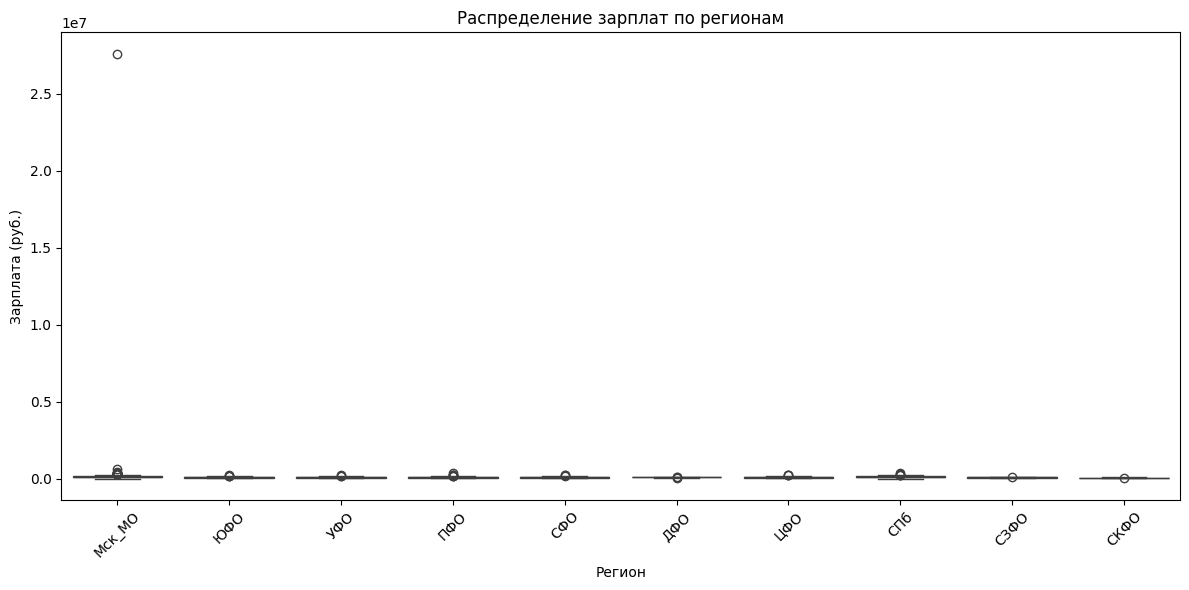

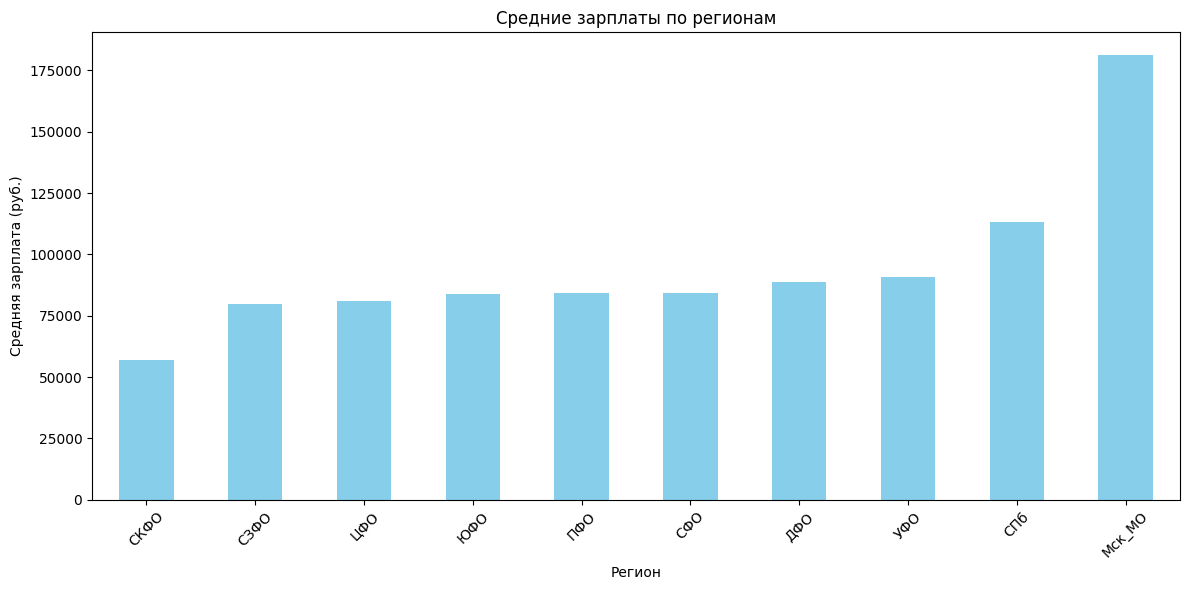


Вывод:
Нет доказательств региональных различий в зарплатах.


In [40]:
# Проверка нормальности
normality_results = {}
for region in df_clean_2['area'].unique():
    region_data = df_clean_2[df_clean_2['area'] == region]['salary']
    if len(region_data) > 3:
        stat, p = stats.shapiro(region_data)
        normality_results[region] = p > 0.05

print("Результаты теста на нормальность (Shapiro-Wilk):")
print(normality_results)

# Тест: ANOVA
anova_result = stats.f_oneway(
    *[df_clean_1[df_clean_2['area'] == region]['salary'] for region in df_clean_2['area'].unique()]
)

print("\nРезультат ANOVA:")
print(f"F-статистика: {anova_result.statistic:.2f}, p-значение: {anova_result.pvalue:.4f}")

# Пост-хок тест Тьюки
if anova_result.pvalue < 0.05:
    print("Отвергаем H0: Средние зарплаты различаются по регионам.")
    tukey = pairwise_tukeyhsd(endog=df_clean_2['salary'], groups=df_clean_2['area'], alpha=0.05)
    print("\nРезультат пост-хок теста Тьюки:")
    print(tukey)
else:
    print("Не отвергаем H0: Нет значимых различий в зарплатах по регионам.")


plt.figure(figsize=(12, 6))
sns.boxplot(x='area', y='salary', data=df_clean_2)
plt.title('Распределение зарплат по регионам')
plt.xlabel('Регион')
plt.ylabel('Зарплата (руб.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('salary_by_region.png')
plt.show()

mean_salaries = df_clean_2.groupby('area')['salary'].mean().sort_values()
plt.figure(figsize=(12, 6))
mean_salaries.plot(kind='bar', color='skyblue')
plt.title('Средние зарплаты по регионам')
plt.xlabel('Регион')
plt.ylabel('Средняя зарплата (руб.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('mean_salary_by_region.png')
plt.show()

print("\nВывод:")
if anova_result.pvalue < 0.05:
    print("Анализ подтверждает, что зарплаты различаются по регионам.")
else:
    print("Нет доказательств региональных различий в зарплатах.")



---



**Гипотеза 3: Дифференциация зарплат по навыкам**



---



H0: Средние зарплаты одинаковы для вакансий с техническими и без технических навыков.

H1: Средние зарплаты выше для вакансий с техническими навыками.

In [51]:
technical_skills = ['SQL', 'Python', 'Power BI']
df['has_technical_skills'] = df['key_skills'].apply(
    lambda x: 1 if any(skill in str(x) for skill in technical_skills) else 0
)
df_clean_3 = df[['has_technical_skills', 'salary']].dropna()


Результаты теста на нормальность (Shapiro-Wilk):
{0: np.False_, 1: np.False_}

Результат t-теста:
t-статистика: -0.19, p-значение: 0.5766
Не отвергаем H0: Нет доказательств влияния технических навыков на зарплату.


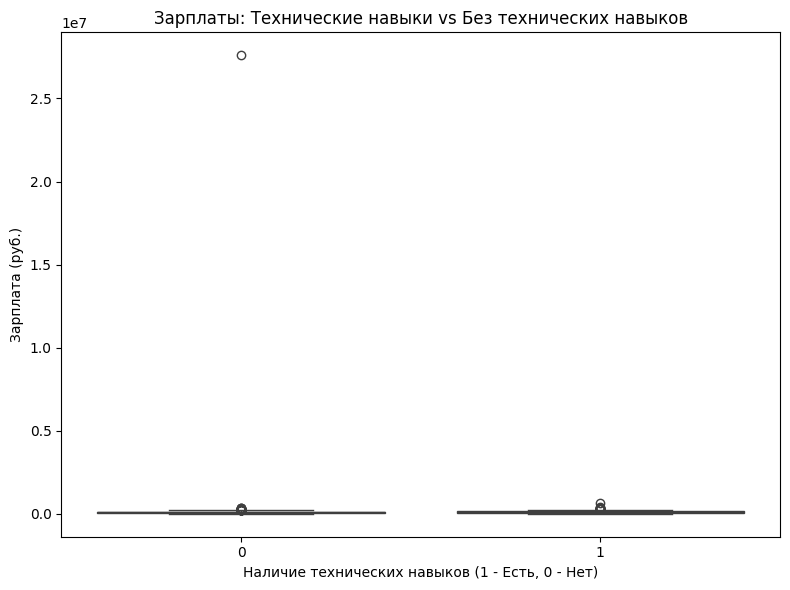


Вывод:
Нет доказательств, что технические навыки влияют на зарплату.


In [52]:
# Проверка нормальности
normality_results = {}
for group in [0, 1]:
    group_data = df_clean_3[df_clean_3['has_technical_skills'] == group]['salary']
    if len(group_data) > 3:
        stat, p = stats.shapiro(group_data)
        normality_results[group] = p > 0.05

print("Результаты теста на нормальность (Shapiro-Wilk):")
print(normality_results)

# Тест: t-тест
tech_salaries = df_clean_3[df_clean_3['has_technical_skills'] == 1]['salary']
non_tech_salaries = df_clean_3[df_clean_3['has_technical_skills'] == 0]['salary']
t_stat, p_value = stats.ttest_ind(tech_salaries, non_tech_salaries, alternative='greater')

print("\nРезультат t-теста:")
print(f"t-статистика: {t_stat:.2f}, p-значение: {p_value:.4f}")

# Интерпретация
if p_value < 0.05:
    print("Отвергаем H0: Технические навыки связаны с более высокими зарплатами.")
else:
    print("Не отвергаем H0: Нет доказательств влияния технических навыков на зарплату.")

plt.figure(figsize=(8, 6))
sns.boxplot(x='has_technical_skills', y='salary', data=df_clean_3)
plt.title('Зарплаты: Технические навыки vs Без технических навыков')
plt.xlabel('Наличие технических навыков (1 - Есть, 0 - Нет)')
plt.ylabel('Зарплата (руб.)')
plt.tight_layout()
plt.savefig('salary_by_skills.png')
plt.show()

print("\nВывод:")
if p_value < 0.05:
    print("Технические навыки (SQL, Python, Power BI) значительно увеличивают зарплату.")
else:
    print("Нет доказательств, что технические навыки влияют на зарплату.")



---



**Гипотеза 4: Влияние типа занятости на зарплаты**



---



H0: Средние зарплаты одинаковы для всех типов занятости.

H1: Средние зарплаты различаются между типами занятости.

In [54]:
df_clean_4 = df[['schedule', 'salary', 'area']].dropna()

Результаты теста на нормальность (Shapiro-Wilk):
{'Полный день': np.False_, 'Удаленная работа': np.False_}

Результат ANOVA:
F-статистика: 0.17, p-значение: 0.9188
Не отвергаем H0: Нет значимых различий в зарплатах по типам занятости.


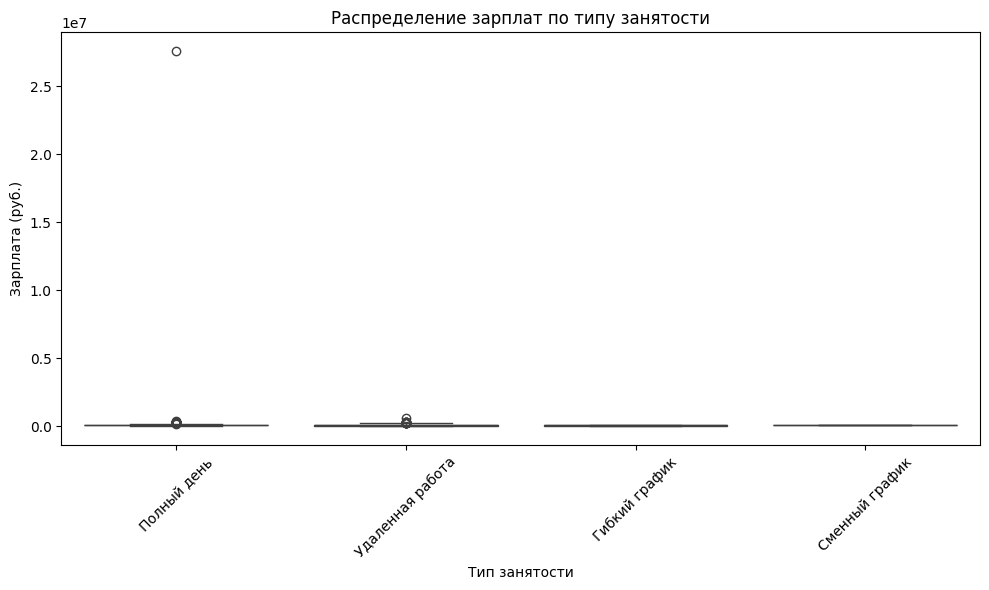


Вывод:
Нет доказательств влияния типа занятости на зарплату.


In [55]:
# Проверка нормальности
normality_results = {}
for schedule in df_clean_4['schedule'].unique():
    schedule_data = df_clean_4[df_clean_4['schedule'] == schedule]['salary']
    if len(schedule_data) > 3:
        stat, p = stats.shapiro(schedule_data)
        normality_results[schedule] = p > 0.05

print("Результаты теста на нормальность (Shapiro-Wilk):")
print(normality_results)

# Тест: ANOVA
anova_result = stats.f_oneway(
    *[df_clean_4[df_clean_4['schedule'] == schedule]['salary'] for schedule in df_clean_4['schedule'].unique()]
)

print("\nРезультат ANOVA:")
print(f"F-статистика: {anova_result.statistic:.2f}, p-значение: {anova_result.pvalue:.4f}")

# Пост-хок тест Тьюки
if anova_result.pvalue < 0.05:
    print("Отвергаем H0: Средние зарплаты различаются по типам занятости.")
    tukey = pairwise_tukeyhsd(endog=df_clean_4['salary'], groups=df_clean_4['schedule'], alpha=0.05)
    print("\nРезультат пост-хок теста Тьюки:")
    print(tukey)
else:
    print("Не отвергаем H0: Нет значимых различий в зарплатах по типам занятости.")

plt.figure(figsize=(10, 6))
sns.boxplot(x='schedule', y='salary', data=df_clean_4)
plt.title('Распределение зарплат по типу занятости')
plt.xlabel('Тип занятости')
plt.ylabel('Зарплата (руб.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('salary_by_schedule_type.png')
plt.show()

print("\nВывод:")
if anova_result.pvalue < 0.05:
    print("Тип занятости влияет на зарплату. Полный день, вероятно, имеет более высокие зарплаты, чем гибкие графики.")
else:
    print("Нет доказательств влияния типа занятости на зарплату.")